## Import Modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os


In [2]:
#Load Dataset
data_path = './Weather-Dataset/sail_decision_2021-2024.csv'
data = pd.read_csv(data_path)
#os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:64"

In [3]:
# visualization
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ
    
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()
    del variables

In [4]:
summary(data).style.background_gradient(cmap='Blues')

#melihat info descriptive statistic
# print(data.describe())

#melihat banyaknya missing value
# print(data.isnull().sum())

data shape: (26304, 30)


,data type,#missing,%missing,#unique,min,max
time,object,0,0.000000,26304,nan,nan
temperature_2m (°C),float64,0,0.000000,71,23.500000,31.100000
relative_humidity_2m (%),int64,0,0.000000,41,54.000000,95.000000
dew_point_2m (°C),float64,0,0.000000,81,17.600000,26.200000
apparent_temperature (°C),float64,0,0.000000,120,24.600000,37.300000
precipitation (mm),float64,0,0.000000,97,0.000000,14.200000
rain (mm),float64,0,0.000000,97,0.000000,14.200000
weather_code (wmo code),int64,0,0.000000,10,0.000000,65.000000
pressure_msl (hPa),float64,0,0.000000,121,1003.900000,1016.100000
cloud_cover (%),int64,0,0.000000,101,0.000000,100.000000


In [5]:
object_cols = data.select_dtypes(include=['object']).columns
df = data.drop(columns=object_cols)
df = df.drop(columns=['wind_wave_peak_period (s)', 'swell_wave_peak_period (s)'])
df = df.dropna()   
summary(df).style.background_gradient(cmap='Blues')

data shape: (17537, 27)


,data type,#missing,%missing,#unique,min,max
temperature_2m (°C),float64,0,0.000000,71,23.500000,31.100000
relative_humidity_2m (%),int64,0,0.000000,41,54.000000,95.000000
dew_point_2m (°C),float64,0,0.000000,81,17.600000,26.200000
apparent_temperature (°C),float64,0,0.000000,120,24.600000,37.300000
precipitation (mm),float64,0,0.000000,81,0.000000,11.400000
rain (mm),float64,0,0.000000,81,0.000000,11.400000
weather_code (wmo code),int64,0,0.000000,10,0.000000,65.000000
pressure_msl (hPa),float64,0,0.000000,121,1003.900000,1016.100000
cloud_cover (%),int64,0,0.000000,101,0.000000,100.000000
wind_speed_100m (km/h),float64,0,0.000000,486,0.000000,53.500000


In [6]:
corr_matrix = df.corr()

In [7]:
corr_matrix.style.background_gradient(cmap='Blues')

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),weather_code (wmo code),pressure_msl (hPa),cloud_cover (%),wind_speed_100m (km/h),wind_direction_100m (°),wind_gusts_10m (km/h),is_day (),direct_radiation (W/m²),daily_weather_code (wmo code),wave_height (m),wave_direction (°),wave_period (s),wind_wave_height (m),wind_wave_direction (°),wind_wave_period (s),swell_wave_height (m),swell_wave_direction (°),swell_wave_period (s),ocean_current_velocity (km/h),ocean_current_direction (°),sailing_decision
temperature_2m (°C),1.000000,-0.638913,0.155175,0.613307,-0.386537,-0.386537,-0.435348,-0.188804,-0.457391,-0.061828,-0.289261,-0.139611,0.012068,0.174933,-0.190895,-0.195205,-0.206699,-0.089141,-0.179933,-0.252421,-0.124724,-0.137050,-0.207200,-0.100302,0.023262,0.107690,0.263050
relative_humidity_2m (%),-0.638913,1.000000,0.656858,-0.088045,0.348943,0.348943,0.462403,-0.090792,0.515712,-0.145473,0.304670,-0.078004,-0.060453,-0.221476,0.547297,-0.077782,0.148209,0.004500,-0.072080,0.142137,-0.133602,-0.103853,0.188103,-0.110832,-0.044840,-0.178345,-0.079864
dew_point_2m (°C),0.155175,0.656858,1.000000,0.486555,0.056429,0.056429,0.158200,-0.298209,0.207067,-0.246202,0.106736,-0.237115,-0.063862,-0.113270,0.514031,-0.288613,-0.012940,-0.077380,-0.266666,-0.064027,-0.291196,-0.264993,0.037168,-0.234695,-0.035504,-0.123714,0.157132
apparent_temperature (°C),0.613307,-0.088045,0.486555,1.000000,-0.238984,-0.238984,-0.256455,-0.273012,-0.254518,-0.739029,-0.194362,-0.756871,0.104005,0.312550,0.214047,-0.637598,-0.180376,-0.063917,-0.669552,-0.263019,-0.656799,-0.449412,-0.163362,-0.317715,-0.052222,0.066581,0.437977
precipitation (mm),-0.386537,0.348943,0.056429,-0.238984,1.000000,1.000000,0.577124,0.036093,0.458861,0.043794,0.143695,0.109695,-0.080155,-0.158714,0.207887,0.081734,0.088195,0.012743,0.086801,0.103371,0.062232,0.045016,0.103984,0.005691,-0.034889,-0.082409,-0.252988
rain (mm),-0.386537,0.348943,0.056429,-0.238984,1.000000,1.000000,0.577124,0.036093,0.458861,0.043794,0.143695,0.109695,-0.080155,-0.158714,0.207887,0.081734,0.088195,0.012743,0.086801,0.103371,0.062232,0.045016,0.103984,0.005691,-0.034889,-0.082409,-0.252988
weather_code (wmo code),-0.435348,0.462403,0.158200,-0.256455,0.577124,0.577124,1.000000,0.006388,0.654412,0.031282,0.211267,0.108282,-0.106824,-0.270538,0.366946,0.082175,0.106320,0.001943,0.100896,0.118761,0.055083,0.014634,0.137667,-0.032188,-0.035203,-0.127929,-0.230763
pressure_msl (hPa),-0.188804,-0.090792,-0.298209,-0.273012,0.036093,0.036093,0.006388,1.000000,-0.059779,0.131985,-0.077235,0.141168,-0.066704,-0.072348,-0.234070,0.207756,-0.007718,0.166613,0.108182,0.119430,0.149904,0.274057,-0.036583,0.236871,-0.120281,0.066104,-0.078177
cloud_cover (%),-0.457391,0.515712,0.207067,-0.254518,0.458861,0.458861,0.654412,-0.059779,1.000000,0.010806,0.354876,0.073222,-0.151500,-0.357713,0.450873,0.064793,0.178297,-0.013274,0.099425,0.172772,0.020533,-0.028413,0.212494,-0.069741,-0.070695,-0.194813,-0.344834
wind_speed_100m (km/h),-0.061828,-0.145473,-0.246202,-0.739029,0.043794,0.043794,0.031282,0.131985,0.010806,1.000000,0.100341,0.958992,0.001854,-0.028578,-0.297157,0.715264,0.130643,0.011649,0.781220,0.198228,0.796068,0.475152,0.124795,0.328302,0.157380,-0.062442,-0.406170


/tmp/ipykernel_177757/267955353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f1_scores_df, x='F1 Score', y='Feature', palette='viridis')


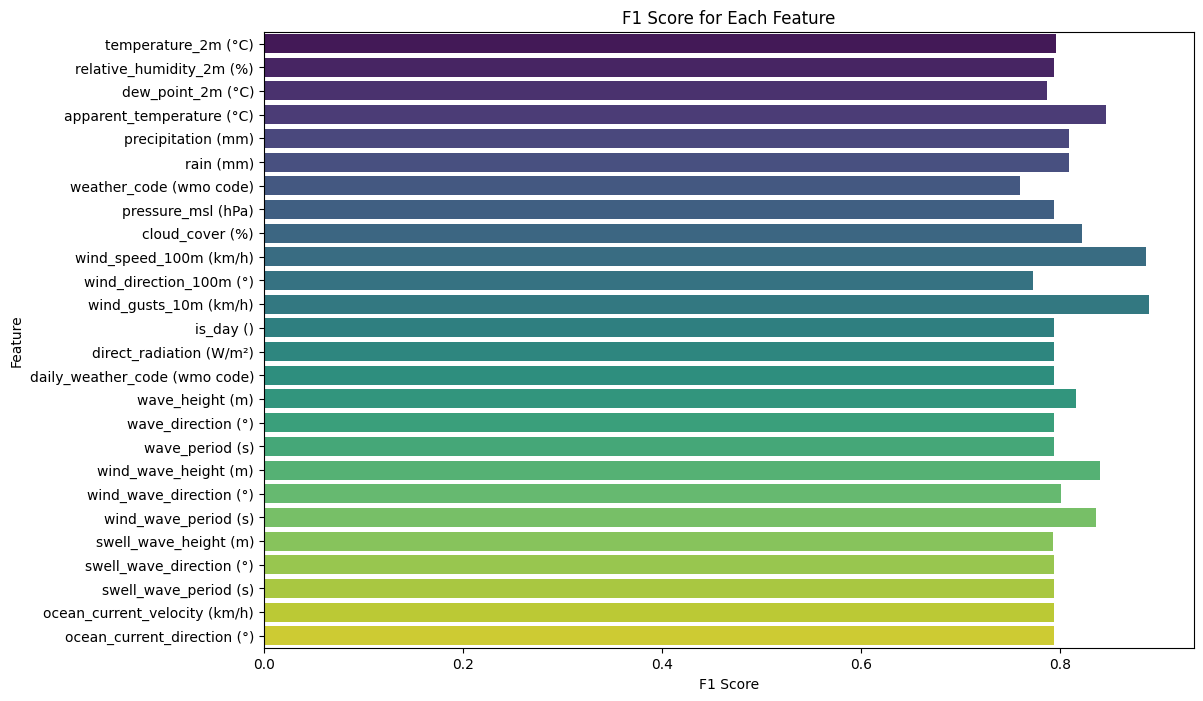

In [8]:
# Extract features and target
y = df['sailing_decision']
X = df.drop(columns=['sailing_decision'])


# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = LogisticRegression()

# Define a custom F1 scorer
f1_scorer = make_scorer(f1_score, average='binary')

# Compute F1 scores using cross-validation
f1_scores = []
for feature in range(X_train.shape[1]):
    scores = cross_val_score(clf, X_train[:, feature].reshape(-1, 1), y_train, cv=5, scoring=f1_scorer)
    f1_scores.append(scores.mean())

# Create a DataFrame for the F1 scores
f1_scores_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'F1 Score': f1_scores
})

# Plot the F1 scores
plt.figure(figsize=(12, 8))
sns.barplot(data=f1_scores_df, x='F1 Score', y='Feature', palette='viridis')
plt.title('F1 Score for Each Feature')
plt.show()



In [9]:
print(f1_scores_df)

                          Feature  F1 Score
0             temperature_2m (°C)  0.795711
1        relative_humidity_2m (%)  0.794441
2               dew_point_2m (°C)  0.787367
3       apparent_temperature (°C)  0.846437
4              precipitation (mm)  0.808958
5                       rain (mm)  0.808958
6         weather_code (wmo code)  0.760008
7              pressure_msl (hPa)  0.794441
8                 cloud_cover (%)  0.822586
9          wind_speed_100m (km/h)  0.886430
10        wind_direction_100m (°)  0.772936
11          wind_gusts_10m (km/h)  0.890130
12                      is_day ()  0.794441
13        direct_radiation (W/m²)  0.794441
14  daily_weather_code (wmo code)  0.794441
15                wave_height (m)  0.816608
16             wave_direction (°)  0.794441
17                wave_period (s)  0.794441
18           wind_wave_height (m)  0.840147
19        wind_wave_direction (°)  0.801065
20           wind_wave_period (s)  0.836478
21          swell_wave_height (m

In [10]:
# Check class distribution
print(df['sailing_decision'].value_counts())

sailing_decision
1    11592
0     5945
Name: count, dtype: int64


In [11]:
binary_label = df['sailing_decision'].values
df = df.drop(columns=['sailing_decision'])

In [12]:


# Random Forest Feature Importance
from sklearn.ensemble import RandomForestClassifier

# Assuming binary_label and df (without sailing_decision) are defined
X = df.values
y = binary_label

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
feature_names = df.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)




In [13]:
print(importance_df)

                          Feature  Importance
9          wind_speed_100m (km/h)    0.292775
11          wind_gusts_10m (km/h)    0.248623
8                 cloud_cover (%)    0.170109
3       apparent_temperature (°C)    0.081436
18           wind_wave_height (m)    0.037881
20           wind_wave_period (s)    0.028226
6         weather_code (wmo code)    0.019836
15                wave_height (m)    0.017106
5                       rain (mm)    0.014900
4              precipitation (mm)    0.013815
0             temperature_2m (°C)    0.010843
10        wind_direction_100m (°)    0.008816
1        relative_humidity_2m (%)    0.006415
23          swell_wave_period (s)    0.006335
16             wave_direction (°)    0.006129
2               dew_point_2m (°C)    0.005357
22       swell_wave_direction (°)    0.004940
19        wind_wave_direction (°)    0.004292
17                wave_period (s)    0.004022
7              pressure_msl (hPa)    0.003437
21          swell_wave_height (m) 

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

steps = 1082
predict_steps = 6
# Create sequences
inp = []
out = []
binary = []
for i in range(len(data_scaled) - (steps + predict_steps - 1)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps:i+steps+predict_steps])
    binary.append(binary_label[i+steps:i+steps+predict_steps])

inp = np.asarray(inp)
out = np.asarray(out)
binary = np.asarray(binary)

# Train-test split
train_test_ratio = 0.7
train_size = int(train_test_ratio * inp.shape[0])

# Split data
x_train_tseries = inp[:train_size, :, :]
x_test_tseries = inp[train_size:, :, :]
y_train_tseries = out[:train_size, :, :]
y_test_tseries = out[train_size:, :, :]
y_train_binary = binary[:train_size, :]
y_test_binary = binary[train_size:, :]

print("x_train_tseries shape:", x_train_tseries.shape)
print("x_test_tseries shape:", x_test_tseries.shape)
print("y_train_binary shape:", y_train_binary.shape)
print("y_test_binary shape:", y_test_binary.shape)

x_train_tseries shape: (11515, 1082, 26)
x_test_tseries shape: (4935, 1082, 26)
y_train_binary shape: (11515, 6)
y_test_binary shape: (4935, 6)


**Non seq2seq without static data, output only binary**

In [15]:
torch.cuda.empty_cache()
gc.collect()

314

**Non Seq2seq with static data**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

x_train_tseries = torch.tensor(x_train_tseries, dtype=torch.float32).to(device)
x_test_tseries = torch.tensor(x_test_tseries, dtype=torch.float32).to(device)
y_train_binary = torch.tensor(y_train_binary, dtype=torch.float32).to(device)
y_test_binary = torch.tensor(y_test_binary, dtype=torch.float32).to(device)


# Define the models and training process
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, input_seq, hidden=None):
        output, hidden = self.gru(input_seq, hidden)
        return output, hidden

class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        output, hidden = self.gru(input_seq, hidden)
        output = self.fc(output)
        output = torch.sigmoid(output)  # Apply sigmoid for binary classification
        return output, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        encoder_output, encoder_hidden = self.encoder(input_seq)

        decoder_hidden = encoder_hidden
        decoder_input = target_seq[:, 0, :].unsqueeze(1)

        outputs = []
        for t in range(target_seq.size(1)):  # Ensure it runs for the length of the target sequence
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output)
            decoder_input = decoder_output

        outputs = torch.cat(outputs, dim=1)
        return outputs

input_size = x_train_tseries.shape[2]
hidden_size = 10
output_size = 1  # Binary output (0 or 1)
num_layers = 1
dropout = 0.2

encoder = EncoderGRU(input_size, hidden_size, num_layers, dropout).to(device)
decoder = DecoderGRU(hidden_size, output_size, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Initialize model, loss function, and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Expand y_train_binary to match the model's expected input shape
    y_train_binary_expanded = y_train_binary.unsqueeze(2).expand(-1, -1, output_size)
    
    # Ensure the output sequence length matches the target sequence length
    outputs = model(x_train_tseries, y_train_binary_expanded)
    outputs = outputs[:, :predict_steps, :]
    
    # Calculate loss
    loss = criterion(outputs.squeeze(2), y_train_binary)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation on test data
model.eval()
with torch.no_grad():
    y_test_binary_expanded = y_test_binary.unsqueeze(2).expand(-1, -1, output_size)
    test_outputs = model(x_test_tseries, y_test_binary_expanded)
    test_outputs = test_outputs[:, :predict_steps, :]
    test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
    print(f'Test Loss: {test_loss.item()}')

    # Calculate accuracy
    test_pred = (test_outputs.squeeze(2) > 0.5).float()
    accuracy = (test_pred == y_test_binary).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')

Using device: cuda


/home/serverai/miniconda3/envs/uas-ai/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0, Loss: 0.7428042888641357
Epoch 10, Loss: 0.7163200378417969
Epoch 20, Loss: 0.693764865398407
Epoch 30, Loss: 0.6745504140853882
Epoch 40, Loss: 0.658065915107727
Epoch 50, Loss: 0.6441380977630615
Epoch 60, Loss: 0.632707417011261
Epoch 70, Loss: 0.6228445768356323
Epoch 80, Loss: 0.61335289478302
Epoch 90, Loss: 0.6042470335960388
Epoch 100, Loss: 0.5948492884635925
Epoch 110, Loss: 0.5842500329017639
Epoch 120, Loss: 0.5730863809585571
Epoch 130, Loss: 0.5626041293144226
Epoch 140, Loss: 0.5537789463996887
Epoch 150, Loss: 0.5470162034034729
Epoch 160, Loss: 0.5418878793716431
Epoch 170, Loss: 0.5376535058021545
Epoch 180, Loss: 0.5338869690895081
Epoch 190, Loss: 0.5303964018821716
Epoch 200, Loss: 0.5270437002182007
Epoch 210, Loss: 0.5237531661987305
Epoch 220, Loss: 0.5205195546150208
Epoch 230, Loss: 0.5173608660697937
Epoch 240, Loss: 0.5142592191696167
Epoch 250, Loss: 0.5111737251281738
Epoch 260, Loss: 0.5080735683441162
Epoch 270, Loss: 0.5049564838409424
Epoch 28

In [17]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1788 MiB |  16913 MiB |  33854 GiB |  33852 GiB |\n|       from large pool |   1786 MiB |  16910 MiB |  33839 GiB |  33837 GiB |\n|       from small pool |      1 MiB |      8 MiB |     14 GiB |     14 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1788 MiB |  16913 MiB |  33854 GiB |  33852 GiB |\n|       from large pool |   1786 MiB |  16910 MiB |

Test Loss: 0.48074251413345337
Test Accuracy: 0.7981763482093811


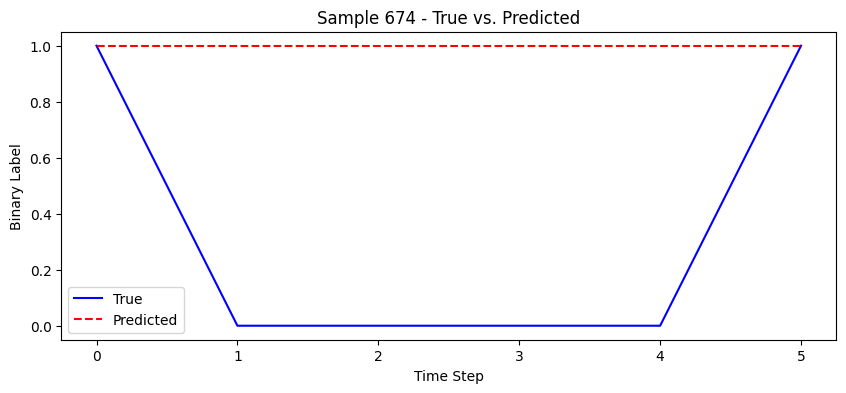

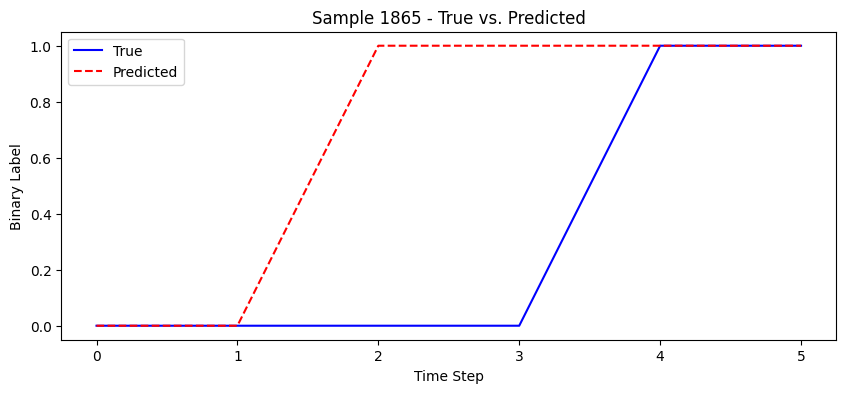

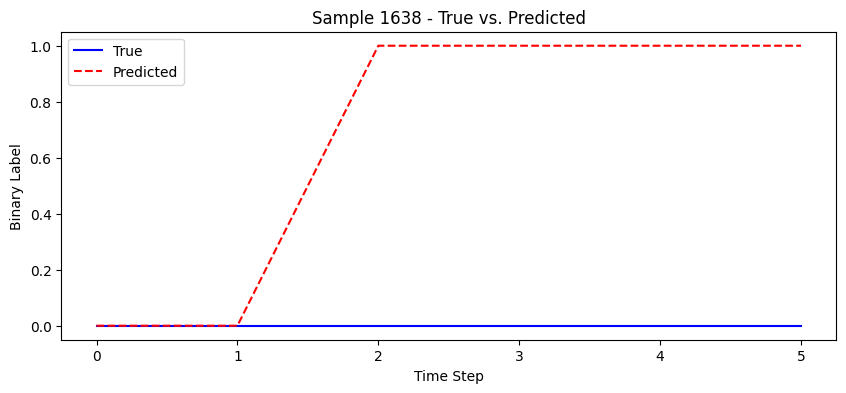

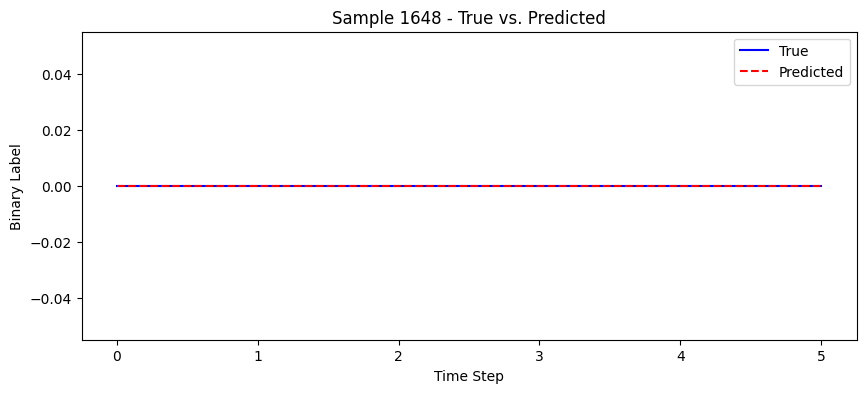

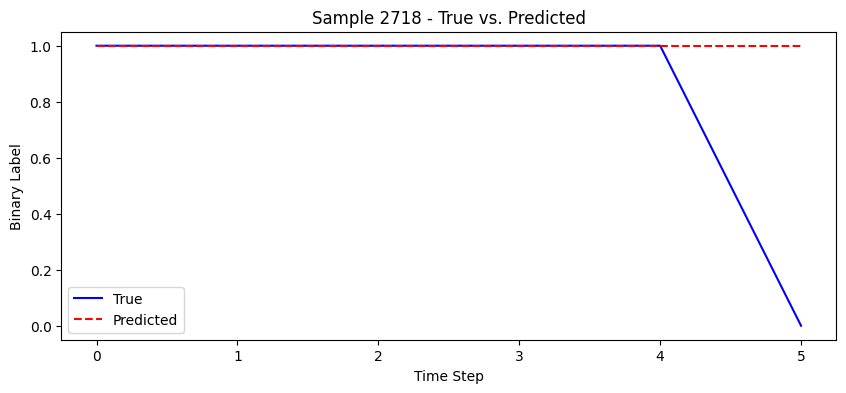

Prediction: [[0. 0. 0. 0. 0. 0.]]
Actual: [0. 0. 0. 0. 0. 0.]


In [18]:
model.eval()
with torch.no_grad():
    y_test_binary_expanded = y_test_binary.unsqueeze(2).expand(-1, -1, output_size)
    test_outputs = model(x_test_tseries, y_test_binary_expanded)
    test_outputs = test_outputs[:, :predict_steps, :]
    
    # Calculate loss
    test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
    print(f'Test Loss: {test_loss.item()}')

    # Convert probabilities to binary predictions
    test_pred = (test_outputs.squeeze(2) > 0.5).float()
    
    # Calculate accuracy
    accuracy = (test_pred == y_test_binary).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')

    # Plotting the results for a few samples
    sample_indices = np.random.choice(range(y_test_binary.shape[0]), size=5, replace=False)
    for i, idx in enumerate(sample_indices):
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_binary[idx].cpu(), 'b-', label='True')
        plt.plot(test_pred[idx].cpu().numpy(), 'r--', label='Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Binary Label')
        plt.title(f'Sample {idx} - True vs. Predicted')
        plt.legend()
        plt.show()

with torch.no_grad():
    sample_data = x_test_tseries[0:1]  # Mengambil satu contoh dari data uji
    sample_target = y_test_binary[0:1].unsqueeze(2).expand(-1, -1, output_size)  # Ekspansi target untuk prediksi

    prediction = model(sample_data, sample_target)
    prediction = prediction[:, :predict_steps, :]

    # Apply threshold to get binary output
    predicted_binary = (prediction.squeeze(2) > 0.5).float()

    print(f'Prediction: {predicted_binary.cpu().numpy()}')
    print(f'Actual: {y_test_binary[0].cpu().numpy()}')

In [19]:
# !echo $CONDA_PREFIX

In [20]:
# #Predict data baru
# import torch
# import torch.nn as nn
# import torch.optim as optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Contoh data
# # x_train_tseries, x_test_tseries harus sudah didefinisikan sebelumnya
# x_train_tseries = torch.tensor(x_train_tseries, dtype=torch.float32).to(device)
# x_test_tseries = torch.tensor(x_test_tseries, dtype=torch.float32).to(device)

# # Define the models and training process
# class EncoderGRU(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
#         super(EncoderGRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

#     def forward(self, input_seq, hidden=None):
#         output, hidden = self.gru(input_seq, hidden)
#         return output, hidden

# class DecoderGRU(nn.Module):
#     def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.2):
#         super(DecoderGRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input_seq, hidden):
#         output, hidden = self.gru(input_seq, hidden)
#         output = self.fc(output)
#         output = torch.sigmoid(output)  # Apply sigmoid for binary classification
#         return output, hidden

# class Seq2Seq(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Seq2Seq, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, input_seq):
#         encoder_output, encoder_hidden = self.encoder(input_seq)

#         decoder_hidden = encoder_hidden
#         decoder_input = torch.zeros((input_seq.size(0), 1, output_size), device=device)  # Initial input to the decoder

#         outputs = []
#         for t in range(predict_steps):  # Predict for predict_steps length
#             decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
#             outputs.append(decoder_output)
#             decoder_input = decoder_output

#         outputs = torch.cat(outputs, dim=1)
#         return outputs

# input_size = x_train_tseries.shape[2]
# hidden_size = 10
# output_size = 1  # Binary output (0 or 1)
# num_layers = 1
# dropout = 0.2

# encoder = EncoderGRU(input_size, hidden_size, num_layers, dropout).to(device)
# decoder = DecoderGRU(hidden_size, output_size, num_layers, dropout).to(device)
# model = Seq2Seq(encoder, decoder).to(device)

# # Initialize model, loss function, and optimizer
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 200
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
    
#     # Expand y_train_binary to match the model's expected input shape
#     #y_train_binary_expanded = y_train_binary.unsqueeze(2).expand(-1, -1, output_size)
    
#     # Ensure the output sequence length matches the target sequence length
#     outputs = model(x_train_tseries)
#     outputs = outputs[:, :predict_steps, :]
    
#     # Calculate loss
#     loss = criterion(outputs.squeeze(2), y_train_binary)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

# # Evaluation on test data
# model.eval()
# with torch.no_grad():
#     test_outputs = model(x_test_tseries)
#     test_outputs = test_outputs[:, :predict_steps, :]
#     test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
#     print(f'Test Loss: {test_loss.item()}')

#     # Calculate accuracy
#     test_pred = (test_outputs.squeeze(2) > 0.5).float()
#     accuracy = (test_pred == y_test_binary).float().mean()
#     print(f'Test Accuracy: {accuracy.item()}')

# # Prediction
# with torch.no_grad():
#     sample_data = x_test_tseries[0:1]  # Mengambil satu contoh dari data uji

#     prediction = model(sample_data)
#     prediction = prediction[:, :predict_steps, :]

#     # Apply threshold to get binary output
#     predicted_binary = (prediction.squeeze(2) > 0.5).float()

#     print(f'Prediction: {predicted_binary.cpu().numpy()}')


## Import Modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os


In [2]:
#Load Dataset
data_path = './Weather-Dataset/sail_decision_2021-2024.csv'
data = pd.read_csv(data_path)
#os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:64"

In [3]:
# visualization
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ
    
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()
    del variables

In [4]:
summary(data).style.background_gradient(cmap='Blues')

#melihat info descriptive statistic
# print(data.describe())

#melihat banyaknya missing value
# print(data.isnull().sum())

data shape: (26304, 30)


,data type,#missing,%missing,#unique,min,max
time,object,0,0.000000,26304,nan,nan
temperature_2m (°C),float64,0,0.000000,71,23.500000,31.100000
relative_humidity_2m (%),int64,0,0.000000,41,54.000000,95.000000
dew_point_2m (°C),float64,0,0.000000,81,17.600000,26.200000
apparent_temperature (°C),float64,0,0.000000,120,24.600000,37.300000
precipitation (mm),float64,0,0.000000,97,0.000000,14.200000
rain (mm),float64,0,0.000000,97,0.000000,14.200000
weather_code (wmo code),int64,0,0.000000,10,0.000000,65.000000
pressure_msl (hPa),float64,0,0.000000,121,1003.900000,1016.100000
cloud_cover (%),int64,0,0.000000,101,0.000000,100.000000


In [5]:
object_cols = data.select_dtypes(include=['object']).columns
df = data.drop(columns=object_cols)
df = df.drop(columns=['wind_wave_peak_period (s)', 'swell_wave_peak_period (s)'])
df = df.dropna()   
summary(df).style.background_gradient(cmap='Blues')

data shape: (17537, 27)


,data type,#missing,%missing,#unique,min,max
temperature_2m (°C),float64,0,0.000000,71,23.500000,31.100000
relative_humidity_2m (%),int64,0,0.000000,41,54.000000,95.000000
dew_point_2m (°C),float64,0,0.000000,81,17.600000,26.200000
apparent_temperature (°C),float64,0,0.000000,120,24.600000,37.300000
precipitation (mm),float64,0,0.000000,81,0.000000,11.400000
rain (mm),float64,0,0.000000,81,0.000000,11.400000
weather_code (wmo code),int64,0,0.000000,10,0.000000,65.000000
pressure_msl (hPa),float64,0,0.000000,121,1003.900000,1016.100000
cloud_cover (%),int64,0,0.000000,101,0.000000,100.000000
wind_speed_100m (km/h),float64,0,0.000000,486,0.000000,53.500000


In [6]:
corr_matrix = df.corr()

In [7]:
corr_matrix.style.background_gradient(cmap='Blues')

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),weather_code (wmo code),pressure_msl (hPa),cloud_cover (%),wind_speed_100m (km/h),wind_direction_100m (°),wind_gusts_10m (km/h),is_day (),direct_radiation (W/m²),daily_weather_code (wmo code),wave_height (m),wave_direction (°),wave_period (s),wind_wave_height (m),wind_wave_direction (°),wind_wave_period (s),swell_wave_height (m),swell_wave_direction (°),swell_wave_period (s),ocean_current_velocity (km/h),ocean_current_direction (°),sailing_decision
temperature_2m (°C),1.000000,-0.638913,0.155175,0.613307,-0.386537,-0.386537,-0.435348,-0.188804,-0.457391,-0.061828,-0.289261,-0.139611,0.012068,0.174933,-0.190895,-0.195205,-0.206699,-0.089141,-0.179933,-0.252421,-0.124724,-0.137050,-0.207200,-0.100302,0.023262,0.107690,0.263050
relative_humidity_2m (%),-0.638913,1.000000,0.656858,-0.088045,0.348943,0.348943,0.462403,-0.090792,0.515712,-0.145473,0.304670,-0.078004,-0.060453,-0.221476,0.547297,-0.077782,0.148209,0.004500,-0.072080,0.142137,-0.133602,-0.103853,0.188103,-0.110832,-0.044840,-0.178345,-0.079864
dew_point_2m (°C),0.155175,0.656858,1.000000,0.486555,0.056429,0.056429,0.158200,-0.298209,0.207067,-0.246202,0.106736,-0.237115,-0.063862,-0.113270,0.514031,-0.288613,-0.012940,-0.077380,-0.266666,-0.064027,-0.291196,-0.264993,0.037168,-0.234695,-0.035504,-0.123714,0.157132
apparent_temperature (°C),0.613307,-0.088045,0.486555,1.000000,-0.238984,-0.238984,-0.256455,-0.273012,-0.254518,-0.739029,-0.194362,-0.756871,0.104005,0.312550,0.214047,-0.637598,-0.180376,-0.063917,-0.669552,-0.263019,-0.656799,-0.449412,-0.163362,-0.317715,-0.052222,0.066581,0.437977
precipitation (mm),-0.386537,0.348943,0.056429,-0.238984,1.000000,1.000000,0.577124,0.036093,0.458861,0.043794,0.143695,0.109695,-0.080155,-0.158714,0.207887,0.081734,0.088195,0.012743,0.086801,0.103371,0.062232,0.045016,0.103984,0.005691,-0.034889,-0.082409,-0.252988
rain (mm),-0.386537,0.348943,0.056429,-0.238984,1.000000,1.000000,0.577124,0.036093,0.458861,0.043794,0.143695,0.109695,-0.080155,-0.158714,0.207887,0.081734,0.088195,0.012743,0.086801,0.103371,0.062232,0.045016,0.103984,0.005691,-0.034889,-0.082409,-0.252988
weather_code (wmo code),-0.435348,0.462403,0.158200,-0.256455,0.577124,0.577124,1.000000,0.006388,0.654412,0.031282,0.211267,0.108282,-0.106824,-0.270538,0.366946,0.082175,0.106320,0.001943,0.100896,0.118761,0.055083,0.014634,0.137667,-0.032188,-0.035203,-0.127929,-0.230763
pressure_msl (hPa),-0.188804,-0.090792,-0.298209,-0.273012,0.036093,0.036093,0.006388,1.000000,-0.059779,0.131985,-0.077235,0.141168,-0.066704,-0.072348,-0.234070,0.207756,-0.007718,0.166613,0.108182,0.119430,0.149904,0.274057,-0.036583,0.236871,-0.120281,0.066104,-0.078177
cloud_cover (%),-0.457391,0.515712,0.207067,-0.254518,0.458861,0.458861,0.654412,-0.059779,1.000000,0.010806,0.354876,0.073222,-0.151500,-0.357713,0.450873,0.064793,0.178297,-0.013274,0.099425,0.172772,0.020533,-0.028413,0.212494,-0.069741,-0.070695,-0.194813,-0.344834
wind_speed_100m (km/h),-0.061828,-0.145473,-0.246202,-0.739029,0.043794,0.043794,0.031282,0.131985,0.010806,1.000000,0.100341,0.958992,0.001854,-0.028578,-0.297157,0.715264,0.130643,0.011649,0.781220,0.198228,0.796068,0.475152,0.124795,0.328302,0.157380,-0.062442,-0.406170


/tmp/ipykernel_177757/267955353.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f1_scores_df, x='F1 Score', y='Feature', palette='viridis')


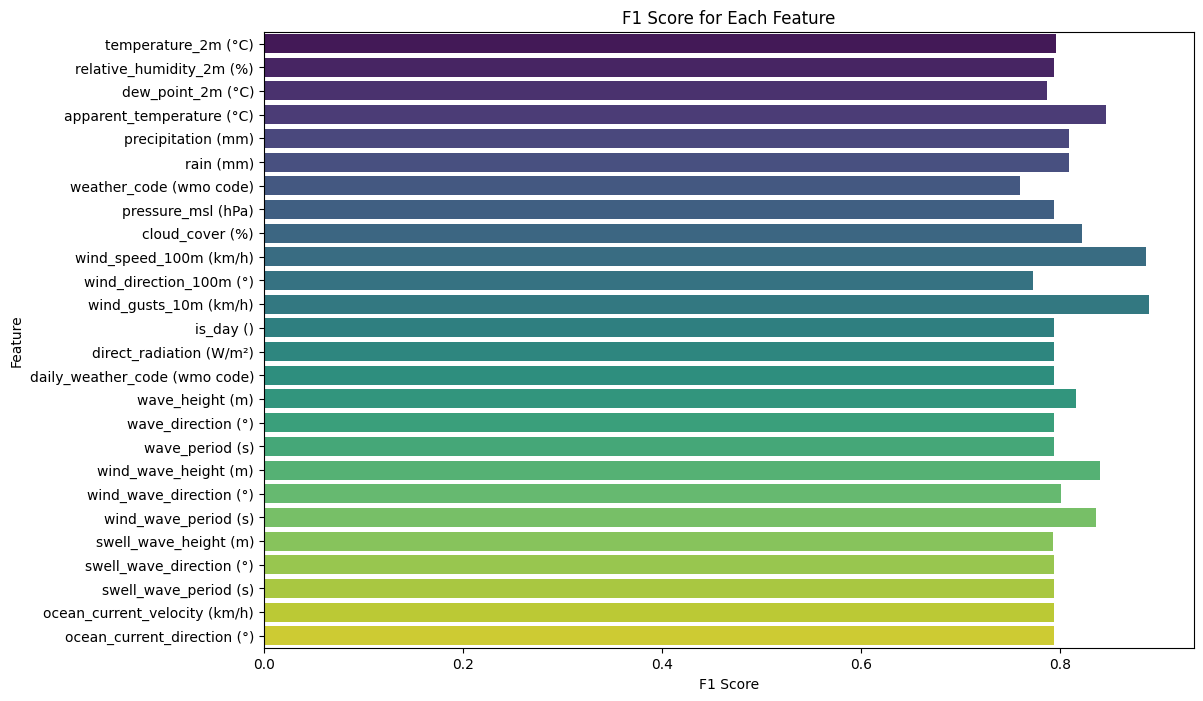

In [8]:
# Extract features and target
y = df['sailing_decision']
X = df.drop(columns=['sailing_decision'])


# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = LogisticRegression()

# Define a custom F1 scorer
f1_scorer = make_scorer(f1_score, average='binary')

# Compute F1 scores using cross-validation
f1_scores = []
for feature in range(X_train.shape[1]):
    scores = cross_val_score(clf, X_train[:, feature].reshape(-1, 1), y_train, cv=5, scoring=f1_scorer)
    f1_scores.append(scores.mean())

# Create a DataFrame for the F1 scores
f1_scores_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'F1 Score': f1_scores
})

# Plot the F1 scores
plt.figure(figsize=(12, 8))
sns.barplot(data=f1_scores_df, x='F1 Score', y='Feature', palette='viridis')
plt.title('F1 Score for Each Feature')
plt.show()



In [9]:
print(f1_scores_df)

                          Feature  F1 Score
0             temperature_2m (°C)  0.795711
1        relative_humidity_2m (%)  0.794441
2               dew_point_2m (°C)  0.787367
3       apparent_temperature (°C)  0.846437
4              precipitation (mm)  0.808958
5                       rain (mm)  0.808958
6         weather_code (wmo code)  0.760008
7              pressure_msl (hPa)  0.794441
8                 cloud_cover (%)  0.822586
9          wind_speed_100m (km/h)  0.886430
10        wind_direction_100m (°)  0.772936
11          wind_gusts_10m (km/h)  0.890130
12                      is_day ()  0.794441
13        direct_radiation (W/m²)  0.794441
14  daily_weather_code (wmo code)  0.794441
15                wave_height (m)  0.816608
16             wave_direction (°)  0.794441
17                wave_period (s)  0.794441
18           wind_wave_height (m)  0.840147
19        wind_wave_direction (°)  0.801065
20           wind_wave_period (s)  0.836478
21          swell_wave_height (m

In [10]:
# Check class distribution
print(df['sailing_decision'].value_counts())

sailing_decision
1    11592
0     5945
Name: count, dtype: int64


In [11]:
binary_label = df['sailing_decision'].values
df = df.drop(columns=['sailing_decision'])

In [12]:


# Random Forest Feature Importance
from sklearn.ensemble import RandomForestClassifier

# Assuming binary_label and df (without sailing_decision) are defined
X = df.values
y = binary_label

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
feature_names = df.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)




In [13]:
print(importance_df)

                          Feature  Importance
9          wind_speed_100m (km/h)    0.292775
11          wind_gusts_10m (km/h)    0.248623
8                 cloud_cover (%)    0.170109
3       apparent_temperature (°C)    0.081436
18           wind_wave_height (m)    0.037881
20           wind_wave_period (s)    0.028226
6         weather_code (wmo code)    0.019836
15                wave_height (m)    0.017106
5                       rain (mm)    0.014900
4              precipitation (mm)    0.013815
0             temperature_2m (°C)    0.010843
10        wind_direction_100m (°)    0.008816
1        relative_humidity_2m (%)    0.006415
23          swell_wave_period (s)    0.006335
16             wave_direction (°)    0.006129
2               dew_point_2m (°C)    0.005357
22       swell_wave_direction (°)    0.004940
19        wind_wave_direction (°)    0.004292
17                wave_period (s)    0.004022
7              pressure_msl (hPa)    0.003437
21          swell_wave_height (m) 

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

steps = 1082
predict_steps = 6
# Create sequences
inp = []
out = []
binary = []
for i in range(len(data_scaled) - (steps + predict_steps - 1)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps:i+steps+predict_steps])
    binary.append(binary_label[i+steps:i+steps+predict_steps])

inp = np.asarray(inp)
out = np.asarray(out)
binary = np.asarray(binary)

# Train-test split
train_test_ratio = 0.7
train_size = int(train_test_ratio * inp.shape[0])

# Split data
x_train_tseries = inp[:train_size, :, :]
x_test_tseries = inp[train_size:, :, :]
y_train_tseries = out[:train_size, :, :]
y_test_tseries = out[train_size:, :, :]
y_train_binary = binary[:train_size, :]
y_test_binary = binary[train_size:, :]

print("x_train_tseries shape:", x_train_tseries.shape)
print("x_test_tseries shape:", x_test_tseries.shape)
print("y_train_binary shape:", y_train_binary.shape)
print("y_test_binary shape:", y_test_binary.shape)

x_train_tseries shape: (11515, 1082, 26)
x_test_tseries shape: (4935, 1082, 26)
y_train_binary shape: (11515, 6)
y_test_binary shape: (4935, 6)


**Non seq2seq without static data, output only binary**

In [15]:
torch.cuda.empty_cache()
gc.collect()

314

**Non Seq2seq with static data**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

x_train_tseries = torch.tensor(x_train_tseries, dtype=torch.float32).to(device)
x_test_tseries = torch.tensor(x_test_tseries, dtype=torch.float32).to(device)
y_train_binary = torch.tensor(y_train_binary, dtype=torch.float32).to(device)
y_test_binary = torch.tensor(y_test_binary, dtype=torch.float32).to(device)


# Define the models and training process
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, input_seq, hidden=None):
        output, hidden = self.gru(input_seq, hidden)
        return output, hidden

class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        output, hidden = self.gru(input_seq, hidden)
        output = self.fc(output)
        output = torch.sigmoid(output)  # Apply sigmoid for binary classification
        return output, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        encoder_output, encoder_hidden = self.encoder(input_seq)

        decoder_hidden = encoder_hidden
        decoder_input = target_seq[:, 0, :].unsqueeze(1)

        outputs = []
        for t in range(target_seq.size(1)):  # Ensure it runs for the length of the target sequence
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output)
            decoder_input = decoder_output

        outputs = torch.cat(outputs, dim=1)
        return outputs

input_size = x_train_tseries.shape[2]
hidden_size = 10
output_size = 1  # Binary output (0 or 1)
num_layers = 1
dropout = 0.2

encoder = EncoderGRU(input_size, hidden_size, num_layers, dropout).to(device)
decoder = DecoderGRU(hidden_size, output_size, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Initialize model, loss function, and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Expand y_train_binary to match the model's expected input shape
    y_train_binary_expanded = y_train_binary.unsqueeze(2).expand(-1, -1, output_size)
    
    # Ensure the output sequence length matches the target sequence length
    outputs = model(x_train_tseries, y_train_binary_expanded)
    outputs = outputs[:, :predict_steps, :]
    
    # Calculate loss
    loss = criterion(outputs.squeeze(2), y_train_binary)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation on test data
model.eval()
with torch.no_grad():
    y_test_binary_expanded = y_test_binary.unsqueeze(2).expand(-1, -1, output_size)
    test_outputs = model(x_test_tseries, y_test_binary_expanded)
    test_outputs = test_outputs[:, :predict_steps, :]
    test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
    print(f'Test Loss: {test_loss.item()}')

    # Calculate accuracy
    test_pred = (test_outputs.squeeze(2) > 0.5).float()
    accuracy = (test_pred == y_test_binary).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')

Using device: cuda


/home/serverai/miniconda3/envs/uas-ai/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0, Loss: 0.7428042888641357
Epoch 10, Loss: 0.7163200378417969
Epoch 20, Loss: 0.693764865398407
Epoch 30, Loss: 0.6745504140853882
Epoch 40, Loss: 0.658065915107727
Epoch 50, Loss: 0.6441380977630615
Epoch 60, Loss: 0.632707417011261
Epoch 70, Loss: 0.6228445768356323
Epoch 80, Loss: 0.61335289478302
Epoch 90, Loss: 0.6042470335960388
Epoch 100, Loss: 0.5948492884635925
Epoch 110, Loss: 0.5842500329017639
Epoch 120, Loss: 0.5730863809585571
Epoch 130, Loss: 0.5626041293144226
Epoch 140, Loss: 0.5537789463996887
Epoch 150, Loss: 0.5470162034034729
Epoch 160, Loss: 0.5418878793716431
Epoch 170, Loss: 0.5376535058021545
Epoch 180, Loss: 0.5338869690895081
Epoch 190, Loss: 0.5303964018821716
Epoch 200, Loss: 0.5270437002182007
Epoch 210, Loss: 0.5237531661987305
Epoch 220, Loss: 0.5205195546150208
Epoch 230, Loss: 0.5173608660697937
Epoch 240, Loss: 0.5142592191696167
Epoch 250, Loss: 0.5111737251281738
Epoch 260, Loss: 0.5080735683441162
Epoch 270, Loss: 0.5049564838409424
Epoch 28

In [17]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1788 MiB |  16913 MiB |  33854 GiB |  33852 GiB |\n|       from large pool |   1786 MiB |  16910 MiB |  33839 GiB |  33837 GiB |\n|       from small pool |      1 MiB |      8 MiB |     14 GiB |     14 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1788 MiB |  16913 MiB |  33854 GiB |  33852 GiB |\n|       from large pool |   1786 MiB |  16910 MiB |

Test Loss: 0.48074251413345337
Test Accuracy: 0.7981763482093811


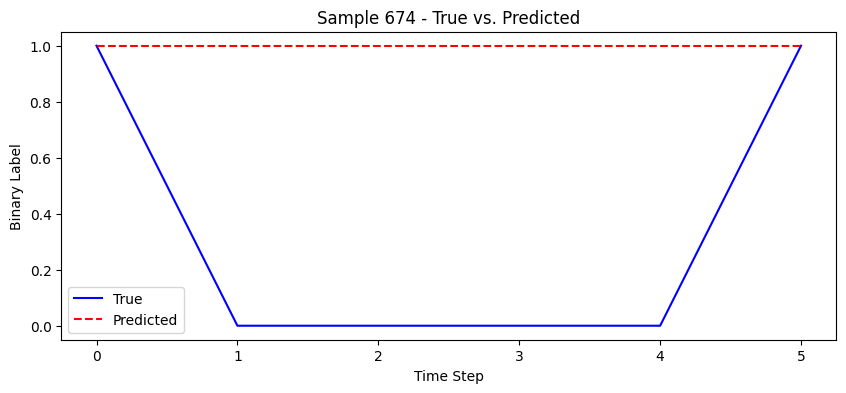

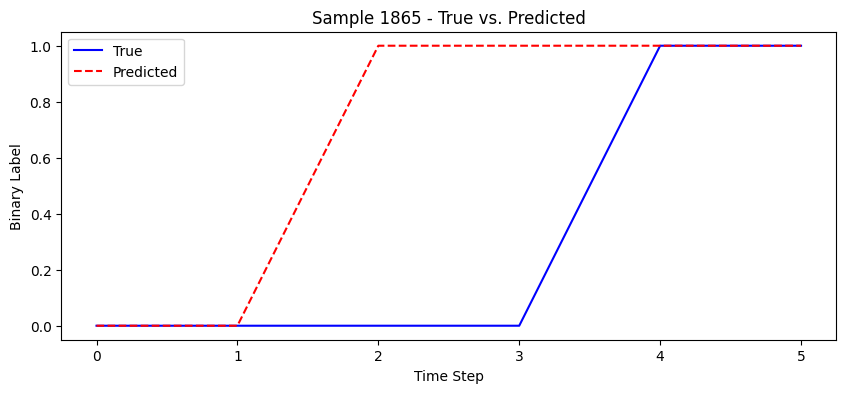

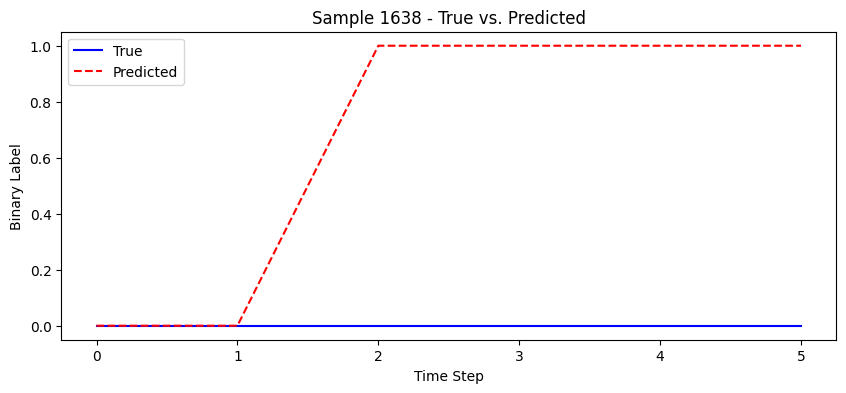

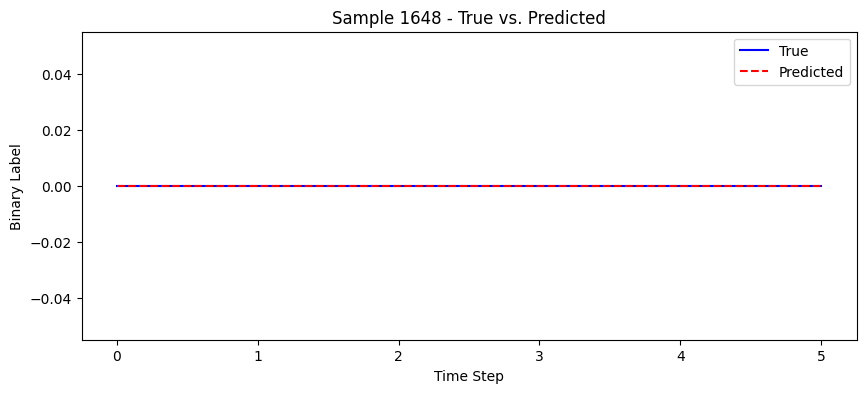

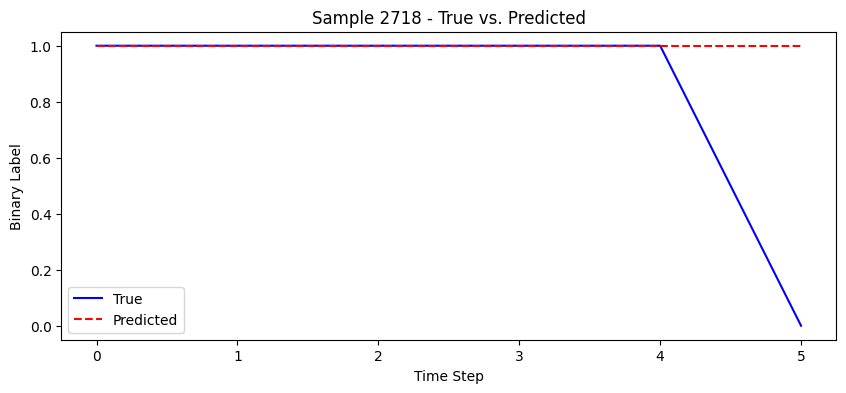

Prediction: [[0. 0. 0. 0. 0. 0.]]
Actual: [0. 0. 0. 0. 0. 0.]


In [18]:
model.eval()
with torch.no_grad():
    y_test_binary_expanded = y_test_binary.unsqueeze(2).expand(-1, -1, output_size)
    test_outputs = model(x_test_tseries, y_test_binary_expanded)
    test_outputs = test_outputs[:, :predict_steps, :]
    
    # Calculate loss
    test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
    print(f'Test Loss: {test_loss.item()}')

    # Convert probabilities to binary predictions
    test_pred = (test_outputs.squeeze(2) > 0.5).float()
    
    # Calculate accuracy
    accuracy = (test_pred == y_test_binary).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')

    # Plotting the results for a few samples
    sample_indices = np.random.choice(range(y_test_binary.shape[0]), size=5, replace=False)
    for i, idx in enumerate(sample_indices):
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_binary[idx].cpu(), 'b-', label='True')
        plt.plot(test_pred[idx].cpu().numpy(), 'r--', label='Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Binary Label')
        plt.title(f'Sample {idx} - True vs. Predicted')
        plt.legend()
        plt.show()

with torch.no_grad():
    sample_data = x_test_tseries[0:1]  # Mengambil satu contoh dari data uji
    sample_target = y_test_binary[0:1].unsqueeze(2).expand(-1, -1, output_size)  # Ekspansi target untuk prediksi

    prediction = model(sample_data, sample_target)
    prediction = prediction[:, :predict_steps, :]

    # Apply threshold to get binary output
    predicted_binary = (prediction.squeeze(2) > 0.5).float()

    print(f'Prediction: {predicted_binary.cpu().numpy()}')
    print(f'Actual: {y_test_binary[0].cpu().numpy()}')

In [19]:
# !echo $CONDA_PREFIX

In [20]:
# #Predict data baru
# import torch
# import torch.nn as nn
# import torch.optim as optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Contoh data
# # x_train_tseries, x_test_tseries harus sudah didefinisikan sebelumnya
# x_train_tseries = torch.tensor(x_train_tseries, dtype=torch.float32).to(device)
# x_test_tseries = torch.tensor(x_test_tseries, dtype=torch.float32).to(device)

# # Define the models and training process
# class EncoderGRU(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
#         super(EncoderGRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

#     def forward(self, input_seq, hidden=None):
#         output, hidden = self.gru(input_seq, hidden)
#         return output, hidden

# class DecoderGRU(nn.Module):
#     def __init__(self, hidden_size, output_size, num_layers=1, dropout=0.2):
#         super(DecoderGRU, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input_seq, hidden):
#         output, hidden = self.gru(input_seq, hidden)
#         output = self.fc(output)
#         output = torch.sigmoid(output)  # Apply sigmoid for binary classification
#         return output, hidden

# class Seq2Seq(nn.Module):
#     def __init__(self, encoder, decoder):
#         super(Seq2Seq, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, input_seq):
#         encoder_output, encoder_hidden = self.encoder(input_seq)

#         decoder_hidden = encoder_hidden
#         decoder_input = torch.zeros((input_seq.size(0), 1, output_size), device=device)  # Initial input to the decoder

#         outputs = []
#         for t in range(predict_steps):  # Predict for predict_steps length
#             decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
#             outputs.append(decoder_output)
#             decoder_input = decoder_output

#         outputs = torch.cat(outputs, dim=1)
#         return outputs

# input_size = x_train_tseries.shape[2]
# hidden_size = 10
# output_size = 1  # Binary output (0 or 1)
# num_layers = 1
# dropout = 0.2

# encoder = EncoderGRU(input_size, hidden_size, num_layers, dropout).to(device)
# decoder = DecoderGRU(hidden_size, output_size, num_layers, dropout).to(device)
# model = Seq2Seq(encoder, decoder).to(device)

# # Initialize model, loss function, and optimizer
# criterion = nn.BCELoss()  # Binary cross-entropy loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 200
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
    
#     # Expand y_train_binary to match the model's expected input shape
#     #y_train_binary_expanded = y_train_binary.unsqueeze(2).expand(-1, -1, output_size)
    
#     # Ensure the output sequence length matches the target sequence length
#     outputs = model(x_train_tseries)
#     outputs = outputs[:, :predict_steps, :]
    
#     # Calculate loss
#     loss = criterion(outputs.squeeze(2), y_train_binary)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

# # Evaluation on test data
# model.eval()
# with torch.no_grad():
#     test_outputs = model(x_test_tseries)
#     test_outputs = test_outputs[:, :predict_steps, :]
#     test_loss = criterion(test_outputs.squeeze(2), y_test_binary)
#     print(f'Test Loss: {test_loss.item()}')

#     # Calculate accuracy
#     test_pred = (test_outputs.squeeze(2) > 0.5).float()
#     accuracy = (test_pred == y_test_binary).float().mean()
#     print(f'Test Accuracy: {accuracy.item()}')

# # Prediction
# with torch.no_grad():
#     sample_data = x_test_tseries[0:1]  # Mengambil satu contoh dari data uji

#     prediction = model(sample_data)
#     prediction = prediction[:, :predict_steps, :]

#     # Apply threshold to get binary output
#     predicted_binary = (prediction.squeeze(2) > 0.5).float()

#     print(f'Prediction: {predicted_binary.cpu().numpy()}')
